# MLOps Exercise: Medical Image Classification with Chest X-Ray Images

## Introduction

In this exercise, you'll gain practical experience with MLOps (Machine Learning Operations) by working on a real-world problem: classifying chest X-ray images to diagnose pneumonia. You'll go through various stages, from data cleaning to deployment, learning how to manage an end-to-end machine learning pipeline.

### Prerequisites

- Basic understanding of Python
- Familiarity with machine learning concepts
- Experience with Jupyter Notebooks

### Tools and Libraries

- Python
- NumPy
- OpenCV
- TensorFlow/Keras
- scikit-learn
- Flask
- Matplotlib
- imbalanced-learn

These libraries should cover most requirements for this exercise, including data manipulation (NumPy, pandas), visualization (Matplotlib), machine learning (scikit-learn, TensorFlow), image processing (OpenCV), and class imbalance treatment (imbalanced-learn).

### Table of Contents

1. [Data Loading and Cleaning](#Data-Loading-and-Cleaning)
2. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
3. [Class Imbalance](#Class-Imbalance)
4. [Model Building](#Model-Building)
5. [Data Augmentation](#Data-Augmentation)
6. [Model Evaluation](#Model-Evaluation)
7. [Model Deployment (Bonus)](#Model-Deployment-(Bonus))


## Environment Setup

Before we begin, let's set up the environment. We'll install the necessary Python packages for this exercise.

```bash
pip install numpy pandas opencv-python matplotlib scikit-learn tensorflow flask
```

You can also create a `requirements.txt` file with the above packages and install them using `pip install -r requirements.txt`.
Be aware that you should download ipykernel and export your env to the jupyter notebook.
```bash
python -m ipykernel install --user --name=my_new_env
```

## Data Loading and Cleaning

### Objective

Load the dataset and clean it by removing corrupted images.

### Guidance

1. Download the Chest X-Ray Images (Pneumonia) dataset and place it in a directory accessible by this notebook. From https://ametice.univ-amu.fr
2. Unzip the dataset and explore its directory structure.
3. Load the images and labels for training.
4. Write a function to scan for and remove any corrupted or invalid images.

### Exercise

Now, load the dataset use the zipfile library and clean it by removing corrupted images. Write your code in the cell below.

```python
import zipfile

zip_file_path = 'path/to/your/zip/file.zip'
extract_path = 'path/to/extract/folder'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
```

After extracting, your dataset should have the following folder structure:

```
/
|-- test/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- train/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- val/
    |-- NORMAL/
    |-- PNEUMONIA/
```

You can point `train_path` and `test_path` to the `train` and `test` folders inside this extracted directory

In [1]:
import zipfile

zip_file_path = 'C:/Users/DESKTOP-FM/Desktop/Dataset.zip'
extract_path = 'C:/Users/DESKTOP-FM/Desktop/Dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [4]:
import os
import cv2

# Define the directory containing the extracted chest X-ray images
data_path = r'C:\Users\DESKTOP-FM\Desktop\MLOps TP1\Dataset\chest_xray'

list_dossiers = ["test", "val", "train"]
list_sous_dossiers = ["NORMAL", "PNEUMONIA"]

# Function to check if an image is corrupted
def is_image_corrupted(image_path):
    try:
        # Attempt to open and read the image using OpenCV
        img = cv2.imread(image_path)
        if img is None:
            return True
        return False
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return True

for dossier in list_dossiers:
    for s_dossier in list_sous_dossiers:
        folder_path = os.path.join(data_path, dossier, s_dossier)
        
        # Check if the folder exists
        if not os.path.exists(folder_path):
            print(f"Folder not found: {folder_path}")
            continue
        
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)

            # Check if the image is corrupted
            if is_image_corrupted(image_path):
                print(f"Removing corrupted image: {image_path}")
                os.remove(image_path)

## Exploratory Data Analysis (EDA)

### Objective

Understand the dataset's basic statistics and visualize the data.

### Guidance

1. Use matplotlib to visualize some sample images from each class.
2. Investigate the distribution of classes (Pneumonia/Normal).

### Exercise

Perform exploratory data analysis on the dataset. Write your code in the cell below.


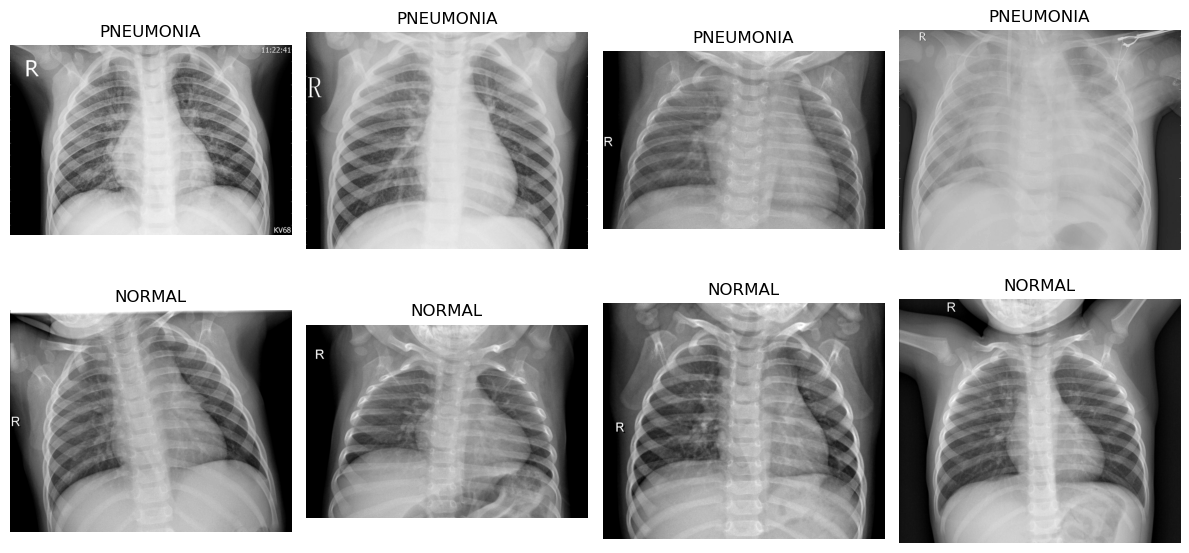

In [6]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to your dataset
dataset_dir = r'C:\Users\DESKTOP-FM\Desktop\MLOps TP1\Dataset\chest_xray\train'

# Define the class labels and corresponding directories
class_labels = ["PNEUMONIA", "NORMAL"]

# Create a subplot grid
num_rows, num_cols = 2, 4  # You can adjust these values
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Randomly select and display images from each class
for i, label in enumerate(class_labels):
    class_dir = os.path.join(dataset_dir, label)
    image_files = os.listdir(class_dir)
    random.shuffle(image_files)
    
    for j in range(num_cols):
        img_path = os.path.join(class_dir, image_files[j])
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img, cmap='gray')  # Assuming grayscale images
        axes[i, j].set_title(label)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Images count')

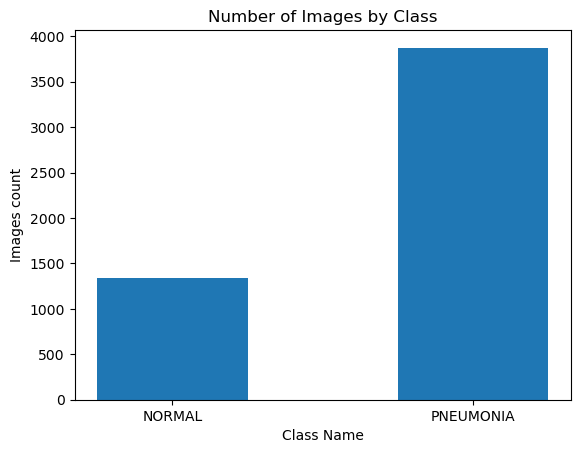

In [8]:
number_classes = {'NORMAL': len(os.listdir(os.path.join(dataset_dir, 'NORMAL'))),
                  'PNEUMONIA': len(os.listdir(os.path.join(dataset_dir, 'PNEUMONIA')))}
plt.bar(number_classes.keys(), number_classes.values(), width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name')
plt.ylabel('Images count')

## Class Imbalance

### Objective

Understand how class imbalance affects model performance and learn ways to mitigate it.

### Guidance

1. Train a baseline model without accounting for class imbalance.
2. Evaluate its performance using metrics like accuracy, precision, recall, and F1-score.
3. Experiment with techniques like class weighting or oversampling methods like SMOTE to balance the classes.

### Exercise

Address the class imbalance and evaluate the impact on the model. Write your code in the cell below.


### Labeling dataset 

In [2]:
import numpy as np
import os
import cv2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

def load_images_labels(imgs, labs, path, label):
    for image_file in os.listdir(path):
        img = cv2.imread(os.path.join(path, image_file))
        img = cv2.resize(img, (224, 224))
        img = img.astype(np.float32) / 255.0
        imgs.append(img)
        labs.append(label)

def labeling(imgs, labs, path):
    normal_path = os.path.join(path, 'NORMAL')
    pneumonia_path = os.path.join(path, 'PNEUMONIA')
    load_images_labels(imgs, labs, normal_path, 0)
    load_images_labels(imgs, labs, pneumonia_path, 1)

In [3]:
path_1 = r'C:\Users\DESKTOP-FM\Desktop\MLOps TP1\Dataset\chest_xray\train'
path_2 = r'C:\Users\DESKTOP-FM\Desktop\MLOps TP1\Dataset\chest_xray\test'
path_3 = r'C:\Users\DESKTOP-FM\Desktop\MLOps TP1\Dataset\chest_xray\val'
img_train, label_train = [], []
img_test, label_test = [], []
img_val, label_val = [], []
labeling(img_train, label_train, path_1)
labeling(img_test, label_test, path_2)
labeling(img_val, label_val, path_3)

In [4]:
x_train = np.array(img_train)
y_train = np.array(label_train)
x_test = np.array(img_test)
y_test = np.array(label_test)
x_val = np.array(img_val)
y_val = np.array(label_val)

#### Creating Model

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

x_train_flatten = x_train.reshape(x_train.shape[0], -1)
logistic_model = LogisticRegression(max_iter=1000)

# Train the model
logistic_model.fit(x_train_flatten, y_train)

# Make predictions on the test set
predictions = logistic_model.predict(x_test)

# Generate the classification report
class_report = classification_report(y_test, predictions)

C:\Users\DESKTOP-FM\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Found array with dim 4. Estimator expected <= 2.

#### Balancing Dataset

In [34]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [37]:
#Adapting model
import numpy as np

class MajorityClassBaseline_2:
    def __init__(self):
        self.majority_class = None
        self.class_weights = None

    def fit(self, y, class_weights=None):
        # Calculate the majority class
        unique, counts = np.unique(y, return_counts=True)
        self.majority_class = unique[np.argmax(counts)]
        self.class_weights = class_weights

    def predict(self, X):
        # Predict the majority class for all instances
        if self.class_weights is not None:
            return np.full(X.shape[0], self.majority_class, dtype=int)
        else:
            return np.full(X.shape[0], self.majority_class)

In [38]:
baseline_model = MajorityClassBaseline_2()
baseline_model.fit(y_train, class_weights=class_weights)
baseline_predictions = baseline_model.predict(x_test)
accuracy = accuracy_score(y_test, baseline_predictions)
classification_report_result = classification_report(y_test, baseline_predictions)

print(f"Accuracy of Baseline Model: {accuracy:.2f}")
print("Classification Report for Baseline Model:")
print(classification_report_result)

Accuracy of Baseline Model: 0.62
Classification Report for Baseline Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



C:\Users\DESKTOP-FM\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DESKTOP-FM\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DESKTOP-FM\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Building

### Objective

Build and train a deep learning model for image classification.

### Guidance

1. Use a Convolutional Neural Network (CNN) for this task.
2. Experiment with different architectures and hyperparameters.

### Exercise

Build and train your model. Write your code in the cell below.


In [ ]:

# Your code here for Model Building


## Data Augmentation

### Objective

Improve your model's performance by using data augmentation techniques.

### Guidance

1. Apply data augmentation techniques like rotation, flipping, and zooming to generate more training data.
2. Retrain your model using the augmented dataset.

### Exercise

Apply data augmentation techniques and evaluate the impact on the model. Write your code in the cell below.


In [ ]:

# Your code here for Data Augmentation


## Model Evaluation

### Objective

Evaluate your model's performance using different metrics and visualization tools.

### Guidance

1. Use metrics like accuracy, precision, recall, and F1-score for evaluation.
2. Plot confusion matrices and ROC curves to visualize your model's performance.

### Exercise

Evaluate your model and interpret the results. Write your code in the cell below.


In [ ]:

# Your code here for Model Evaluation


## Model Deployment (Bonus)

### Objective

Learn the basics of deploying a machine learning model.

### Guidance

1. Save your trained model.
2. Use Flask to create a simple REST API to serve your model.

### Exercise

Deploy your model using Flask. Write your code in the cell below.


In [ ]:

# Your code here for Model Deployment (Bonus)



### Next Steps

1. Experiment with more advanced architectures and hyperparameters.
2. Deploy your model
3. Integrate your model into a web application or other services.
4. Learn more about MLOps best practices and tools.


